In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy.stats as st
from numpy import fft
import random

from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów

#smutne wykresy
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [9]:
def plotowanie(x, y, n_ch, Fs, titlex='Czas [s]', titley='Amplituda [µV]',xmin=0, xmax=0, title='Sygnał z kanału '):
    for ch in range(n_ch):
        if xmin == 0:
            xmin = x[0]
        if xmax == 0:
            xmax=xmin+len(y)/Fs
        plt.subplot(n_ch,1,ch+1)
        plt.plot(x, y[:,ch])
        plt.xlabel(titlex)
        plt.ylabel(titley)
        plt.title(title+str(ch+1)) 
        plt.tight_layout()
        plt.xlim(xmin, xmax)
    plt.show()

In [10]:
def szukanie_peakow(signal, threshold=670.098):
    list_of_indexes = []
    for index, value in enumerate(signal):
        if value > threshold:
            list_of_indexes.append(index)
    list_of_points = []          
    counter = 0
    peak_indexes = []
    peak_values = []
    for i in range(0, int(len(list_of_indexes))-1):
        counter += 1
        if list_of_indexes[i] + 1 != list_of_indexes[i+1] or i == int(len(list_of_indexes))-2:
            start_of_scope = (list_of_indexes[i]-counter) + 1
            end_of_scope = list_of_indexes[i] + 1
            signal_list = signal.tolist()
            peak_indexes.append(signal_list.index(max(signal[start_of_scope:end_of_scope])))
            peak_values.append(max(signal[start_of_scope:end_of_scope]))
            counter = 0
    peak_indexes = np.array(peak_indexes)
    return peak_indexes, peak_values

Wczytanie sygnału

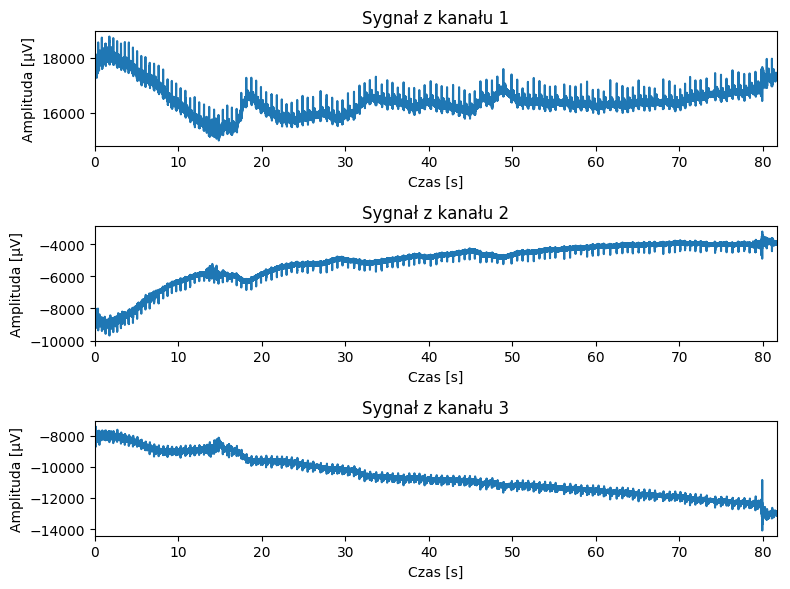

In [11]:
n_ch = 3
Fs = 2048
dt = 1/Fs
calibrationParam = 0.0715 #mikro volty na punkt

nazwaSygnalu = 'Mateusz_Po_pompkach.raw'

with open(nazwaSygnalu, 'rb') as f_out:
    s = np.fromfile(f_out, dtype='float32')
s_mixed = np.reshape(s,(len(s)//n_ch,n_ch))
s_mixed = s_mixed * calibrationParam
t = np.arange(0,len(s_mixed)/Fs,dt)

plotowanie(t,s_mixed,n_ch, Fs)

Filtrowanie

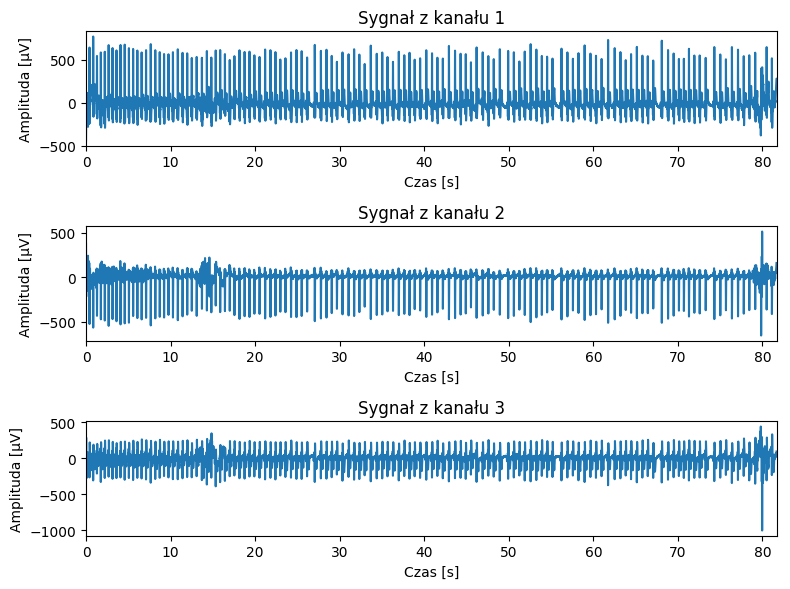

In [12]:
s_mixed_filt = np.zeros(s_mixed.shape)

for ch in range(n_ch):
    [b,a] = butter(5, 0.5/(Fs/2), btype = 'highpass')
    s_mixed_filt[:,ch] = filtfilt(b,a,s_mixed[:,ch])
    [b,a] = butter(5, 35/(Fs/2), btype = 'lowpass')
    s_mixed_filt[:,ch] = filtfilt(b,a,s_mixed_filt[:,ch])
plotowanie(t, s_mixed_filt,n_ch, Fs)

Przycinanie sygnału

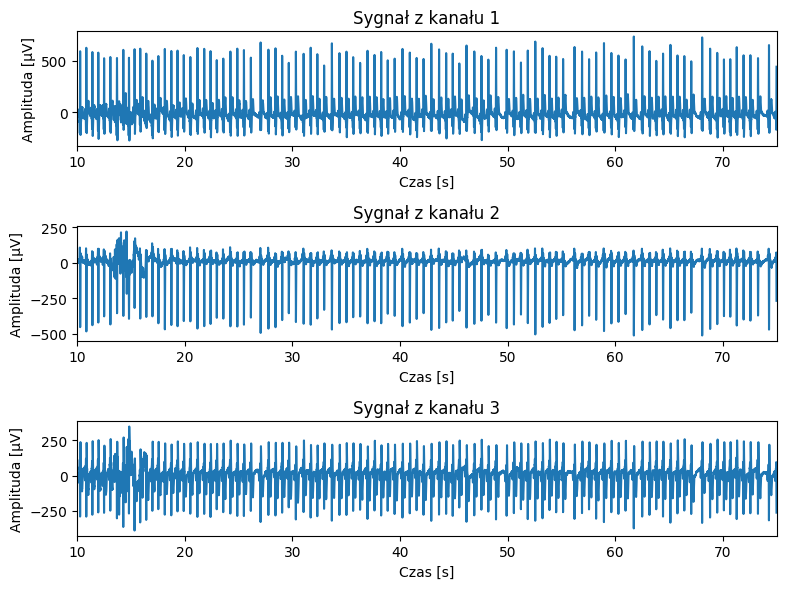

In [13]:
tmin = 10
tmax = 75

tmin_w_probkach = int(tmin * Fs) #granice czasu
tmax_w_probkach = int(tmax * Fs)
t = np.arange(0,len(s_mixed)/Fs,dt)
t_wyciety = t[tmin_w_probkach:tmax_w_probkach]

s_wyciety = np.zeros([len(t_wyciety),n_ch])
s_wyciety[:] = s_mixed_filt[tmin_w_probkach:tmax_w_probkach] #docinamy listę

plotowanie(t_wyciety,s_wyciety,n_ch, Fs)

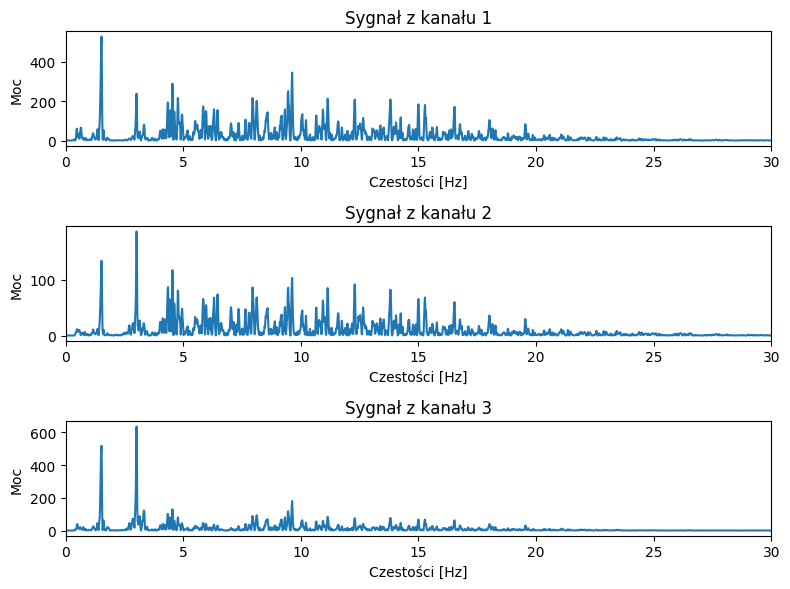

In [14]:
Pxx_spec = np.zeros((int(len(s_wyciety)/2)+1, n_ch))

for ch in range(n_ch):
    f, Pxx_spec[:,ch] = sg.periodogram(s_wyciety[:,ch], Fs, 'flattop', scaling = 'spectrum')

plotowanie(f, Pxx_spec, n_ch, Fs, titlex = 'Czestości [Hz]', titley = 'Moc', xmax=30)


Odprowadzenie Einthovena

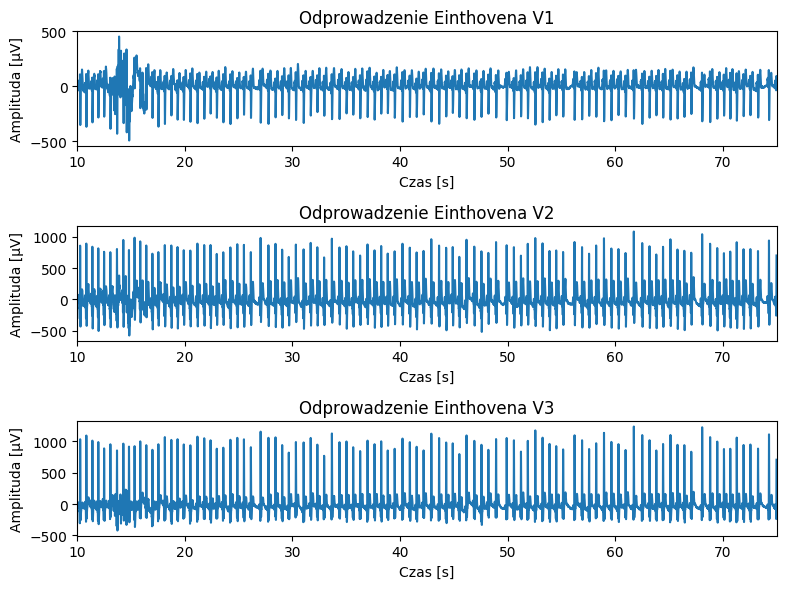

In [15]:
noga = s_wyciety[:,0]
lewa = s_wyciety[:,1]
prawa = s_wyciety[:,2]

v1 = lewa - prawa
v2 = noga - prawa
v3 = noga - lewa

v = np.stack((v1, v2, v3), axis = 1)

plotowanie(t_wyciety, v, n_ch, Fs, title = 'Odprowadzenie Einthovena V')

Prawo Einthovena

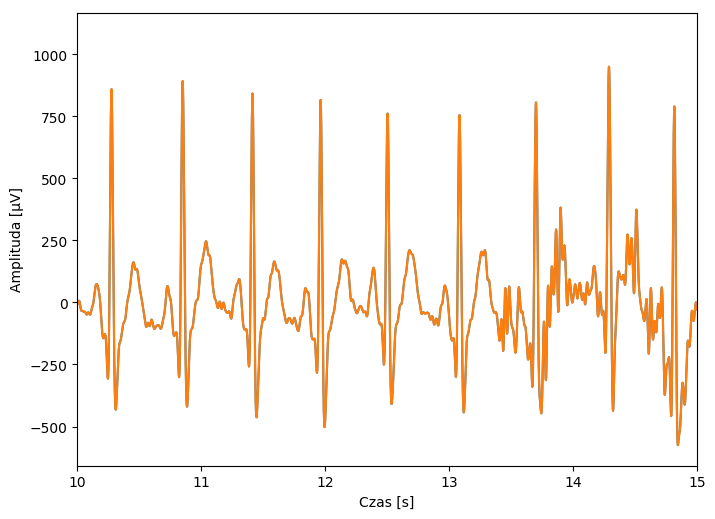

In [16]:
plt.plot(t_wyciety, v2)
plt.plot(t_wyciety, v1+v3)
plt.xlim(tmin,tmin+5)
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda [µV]')
plt.show()

assert (v1+v3).all() == v2.all()

Odprowadzenia Goldberga

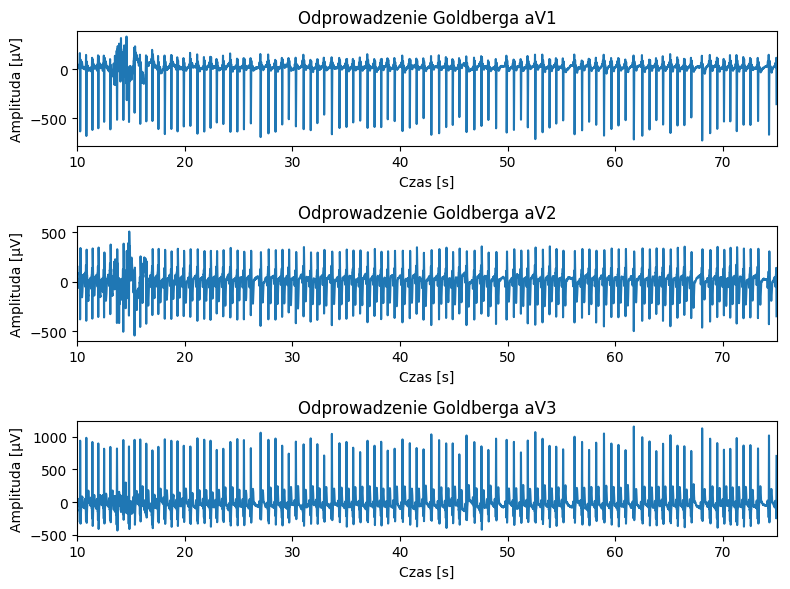

In [17]:
av1 = lewa - (prawa + noga)/2
av2 = prawa - (lewa + noga)/2
av3 = noga - (lewa + prawa)/2

a = np.stack((av1, av2, av3), axis = 1)
plotowanie(t_wyciety, a, n_ch, Fs, title = 'Odprowadzenie Goldberga aV')

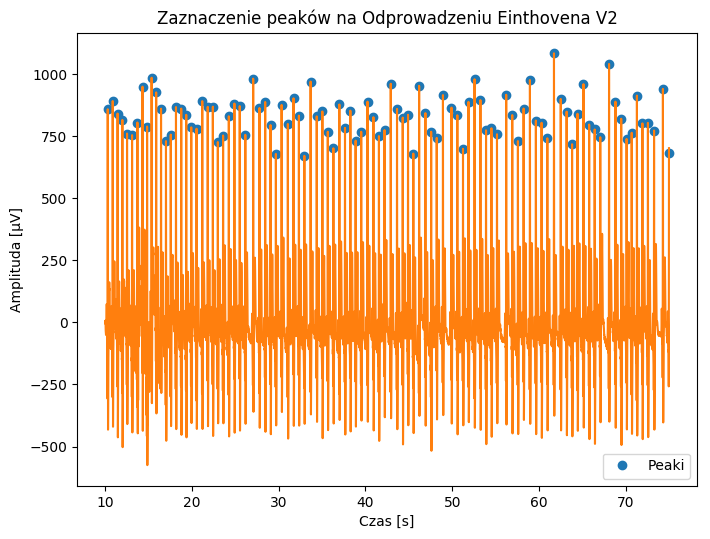

Tętno obliczone wynosi: 91.38461538461539


In [18]:
signal = v2

peak_indexes, peak_values = szukanie_peakow(signal)
peak_in_seconds = (peak_indexes / Fs) + tmin
peaks = plt.plot(peak_in_seconds, peak_values, "o")
plt.plot(t_wyciety, signal)
plt.title('Zaznaczenie peaków na Odprowadzeniu Einthovena V2')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda [µV]')
plt.legend((peaks),('Peaki',), loc=4, fancybox=True)
plt.show()

tentno = (len(peak_in_seconds)/(tmax-tmin))*60
print(f'Tętno obliczone wynosi: {tentno}')

Nałożenie na siebie na wykresie kilku cykli

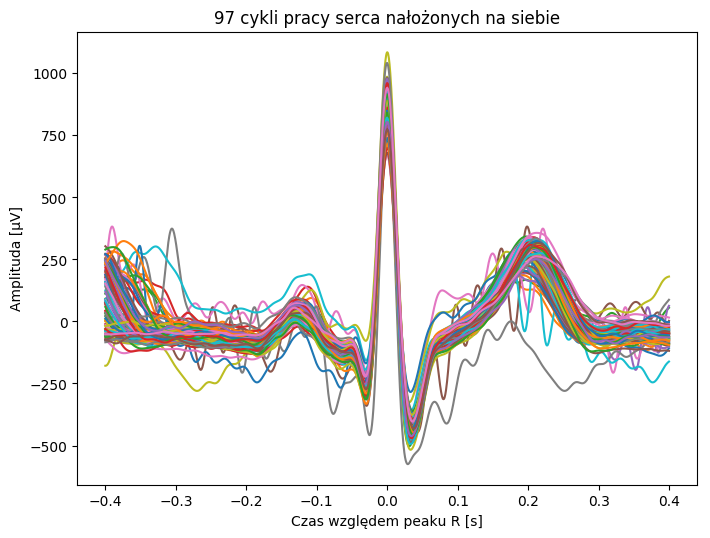

In [26]:
szerokosc = 0.4
t_wykresow = np.arange(-szerokosc, szerokosc, dt )
liczba_cykli = len(peak_indexes)
plt.title(f'{liczba_cykli-2} cykli pracy serca nałożonych na siebie')
plt.xlabel('Czas względem peaku R [s]')
plt.ylabel('Amplituda [µV]')
for i in range(1,liczba_cykli-1):
    punkt = peak_indexes[i]
    signow = signal[punkt-int(szerokosc * Fs):punkt+int(szerokosc * Fs)+1]
    plt.plot(t_wykresow, signow)

Periodogram cykli pracy serca

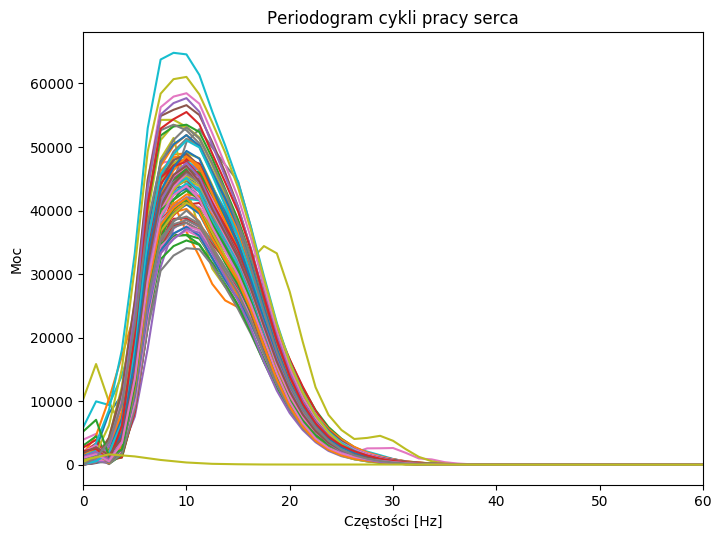

In [27]:
for i in range(liczba_cykli):
    punkt = peak_indexes[i]
    signow = signal[punkt-int(szerokosc * Fs):punkt+int(szerokosc * Fs)+1]
    f, Pxx_spec = sg.periodogram(signow, Fs, 'flattop', scaling = 'spectrum')
    plt.plot(f, Pxx_spec)
    plt.xlim(0, 60)
plt.title('Periodogram cykli pracy serca')
plt.xlabel('Częstości [Hz]')
plt.ylabel('Moc')
plt.show()

Jeden cykl pracy serca - opisany

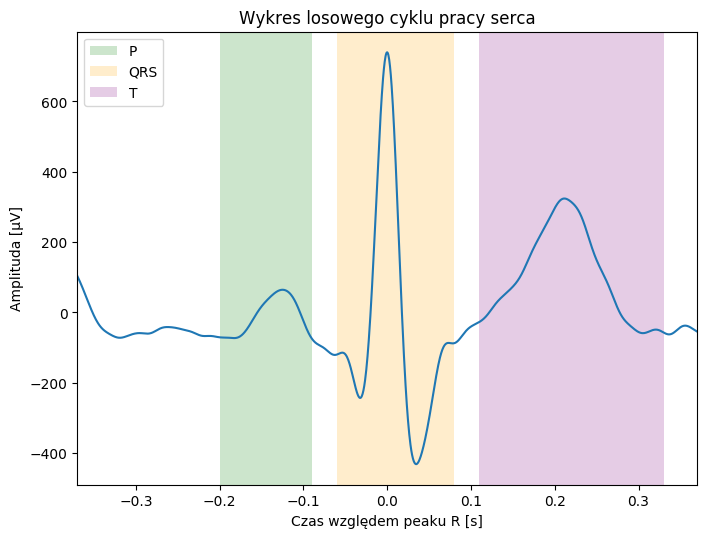

In [28]:
peak = random.choice(peak_indexes)
szerokosc = 0.5
peak_w_czasie = peak / Fs
t_start = 0 - szerokosc
t_stop = 0 + szerokosc

cycle = np.zeros(len(t))
cycle = signal[int(peak - szerokosc * Fs):int(peak + szerokosc * Fs)] #docinamy listę
t_wykresow = np.arange(-szerokosc, szerokosc, dt )

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(t_wykresow, cycle)
P = plt.axvspan(t_start + .30, t_start +.41, alpha=0.2, facecolor='green', label = 'P')
QRS = plt.axvspan(t_start +.44, t_start +.58, alpha=0.2, facecolor='orange', label = 'QRS')
T = plt.axvspan(t_start +.61, t_start +.83, alpha=0.2, facecolor='purple', label = 'T')
plt.legend((P, QRS, T),('P', 'QRS', 'T'))
plt.xlim(-0.37, 0.37)
plt.title('Wykres losowego cyklu pracy serca')
plt.xlabel('Czas względem peaku R [s]')
plt.ylabel('Amplituda [µV]')
plt.show()

HRV

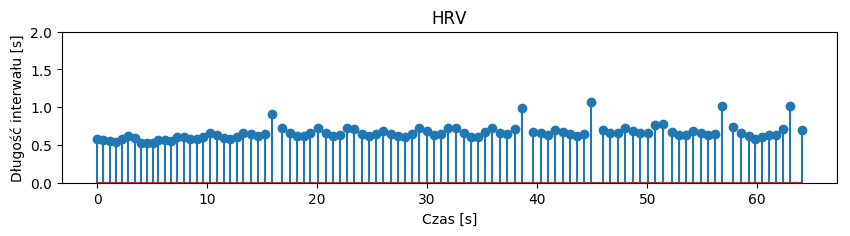

In [29]:
Is_y = []
for i in range(len(peak_indexes)-1):
    I = peak_indexes[i+1] - peak_indexes[i]
    Is_y.append(I)
Is_x = [0]
I_x = 0
for i in Is_y:
    I_x = I_x + i
    Is_x.append(I_x)
Is_x.pop(-1)
Is_x_sekundy = np.array(Is_x)/Fs
Is_y_sekundy = np.array(Is_y)/Fs
fig = plt.figure(figsize=(10, 2), dpi=100)
plt.stem(Is_x_sekundy, Is_y_sekundy)
plt.ylim(0, 2)

plt.xlabel('Czas [s]')
plt.ylabel('Długość interwału [s]')
plt.title('HRV')
plt.show()

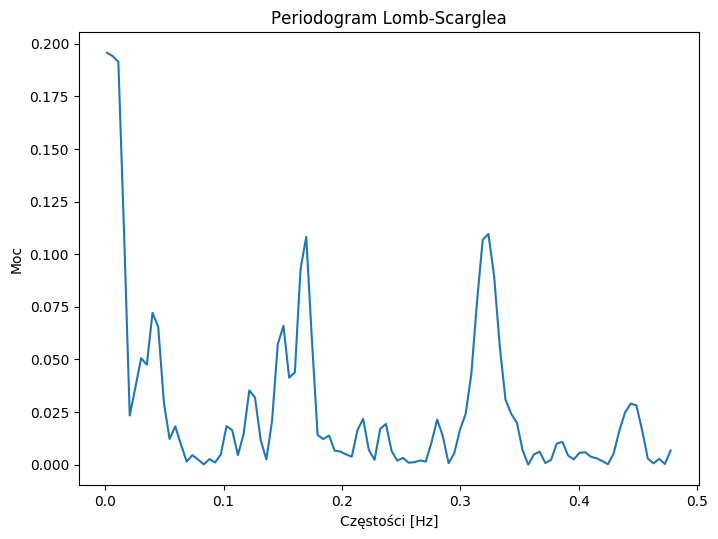

In [30]:
f = np.linspace(0.01, 3, 100)
Y_HRV = Is_y_sekundy - np.mean(Is_y_sekundy)
lomb = sg.lombscargle(Is_x_sekundy, Y_HRV, f, normalize=True)
plt.xlabel('Częstości [Hz]')
plt.ylabel('Moc')
plt.title('Periodogram Lomb-Scarglea')
plt.plot(f/(2*np.pi), lomb)
plt.show()